In [0]:
## disable future warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
from glob import glob
import pylab
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import csv
import random
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import gc
from skimage.transform import resize
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

## input dir
data_dir = os.path.join(os.getcwd() + '/rsna')

###Exploratory Data Analysis : EDA


In [21]:
## list all the files in the input folder
print("\n".join(os.listdir(data_dir)))


stage_2_train_labels.csv
stage_2_sample_submission.csv
stage_2_test_images
stage_2_train_images
stage_2_detailed_class_info.csv
GCP Credits Request Link - RSNA.txt


In [0]:
## load and set file/folder variables
details_class_info_csv = os.path.join(data_dir, 'stage_2_detailed_class_info.csv')
labeled_boxes_csv = os.path.join(data_dir, 'stage_2_train_labels.csv')
train_images_folder = os.path.join(data_dir, 'stage_2_train_images')
test_images = os.path.join(data_dir, 'stage_2_test_images')

In [23]:
## load the csv's as dataframe 
labled_df = pd.read_csv(labeled_boxes_csv)
print("Content of the stage_2_train_labels.csv: \n")
labled_df.head()



Content of the stage_2_train_labels.csv: 



patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [24]:

class_info_df = pd.read_csv(details_class_info_csv)
print("\n\n\nContent of the stage_2_detailed_class_info.csv:\n")
class_info_df.head()




Content of the stage_2_detailed_class_info.csv:



patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

**Description of the files:**    
`stage_2_train_labels.csv` : training set with patientId and labels    
`stage_2_sample_submission.csv`      
`stage_2_test_images` : folder containing test images    
`stage_2_train_images` : folder contaning training images     
`stage_2_detailed_class_info.csv` : contains more details about the patient and lung opacities    
`GCP Credits Request Link - RSNA.txt` :   

In [0]:
def get_dcm_image(patientId, data_type="train"):
  '''returns the path to the corresponding patientId 
  image file path
  '''
  filepath = ''
  if data_type == 'train':
    filepath = os.path.join(data_dir, 'stage_2_train_images/%s.dcm' % patientId)
  else:
    filepath = os.path.join(data_dir, 'stage_2_test_images/%s.dcm' % patientId)

  return str(filepath)


#### View files types, content and format

In [26]:
## viewing the individual image sample given patientId
def view_individual_patient_image(patientId, 
                                  cmap_value=pylab.cm.gist_gray):
  '''Views the imdividuals patients image 
  patientId : patient's id
  '''
  dcm_file = get_dcm_image(patientId)
  dcm_data = pydicom.read_file(dcm_file)
  sample_img = dcm_data.pixel_array
  pylab.imshow(sample_img, cmap=cmap_value)
  pylab.axis('off')

## view the content of the dcm file 
pid = labled_df['patientId'][4]
dcm_file = get_dcm_image(pid)
dcm_data = pydicom.read_file(dcm_file)
print("dcm_file format for patientId=4\n")
print(dcm_data)


dcm_file format for patientId=4

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0020) Patient ID                          LO: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                    

#### View different classes of patient images      
It will help us manually guess the what we are trying to classify and    
what approach we can take.



image of patientId=4 with class 'Lung Opacity'


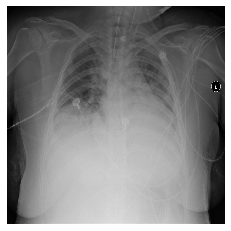

In [27]:

## view image
print("\n\nimage of patientId=4 with class 'Lung Opacity'")
view_individual_patient_image(pid)



image of patientId=1 with class 'No Lung Opacity / Not Normal'


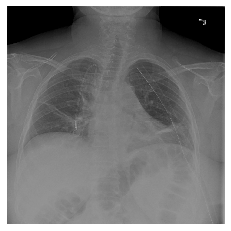

In [319]:
print("\n\nimage of patientId=1 with class 'No Lung Opacity / Not Normal'")
view_individual_patient_image(labled_df['patientId'][1])




image of patientId=3 with class 'Normal'


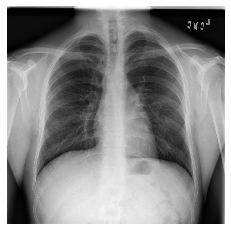

In [166]:
print("\n\nimage of patientId=3 with class 'Normal'")
view_individual_patient_image(labled_df['patientId'][3])



image of patientId=2 with class 'No Lung Opacity / Not Normal'


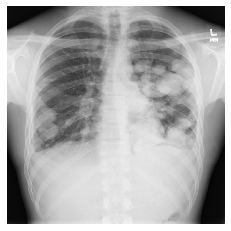

In [167]:
print("\n\nimage of patientId=2 with class 'No Lung Opacity / Not Normal'")
view_individual_patient_image(labled_df['patientId'][2])



image of patientId=38 with class 'No Lung Opacity / Not Normal'


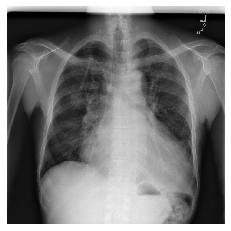

In [214]:
print("patient with heart condition")
print("\n\nimage of patientId=38 with class 'No Lung Opacity / Not Normal'")
view_individual_patient_image(labled_df['patientId'][38])

                                  patientId     x      y  width  height  \
14879  924f4f8b-fc27-4dfd-b5ae-59c40715e150  85.0  215.0  378.0   681.0   

       Target  
14879       1  


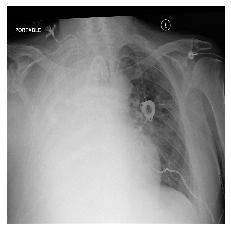

In [222]:
## missing half lung
pid_missing = box_df.loc[box_df['patientId'] == "924f4f8b-fc27-4dfd-b5ae-59c40715e150"]
print(pid_missing)
view_individual_patient_image(labled_df['patientId'][14879])

**Check missing values**

In [241]:
def missing_data(data):
  '''
  '''
  total = data.isnull().sum().sort_values(ascending = False)
  percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
  return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

## check for missing data 'stage_2_train_labels'
missing_data(labled_df)

height         width             y             x  Target  \
Total    20672.000000  20672.000000  20672.000000  20672.000000     0.0   
Percent     68.389188     68.389188     68.389188     68.389188     0.0   

         patientId  
Total          0.0  
Percent        0.0

In [242]:
## check for missing data in stage_2_detailed_class_info
missing_data(class_info_df)

class  patientId
Total      0.0        0.0
Percent    0.0        0.0

#### Shape of the data

Shape of stage_2_detailed_class_info.csv : (30227, 2)
Unique values : 26684




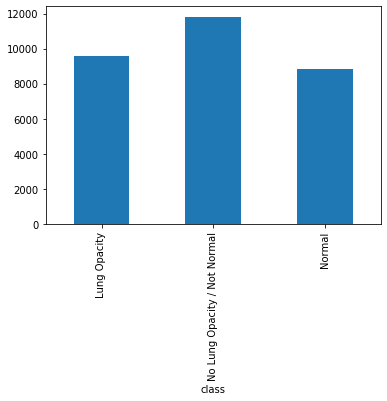

In [12]:
## view the dimensions, counts
print("Shape of stage_2_detailed_class_info.csv : {0}".format(class_info_df.shape))
print("Unique values : {0}\n\n".format(class_info_df['patientId'].value_counts().shape[0]))

## plot the distribution of classes
class_info_df.groupby('class').size().plot.bar()


Shape of stage_2_train_labels.csv.csv : (30227, 6)
Unique values : 26684




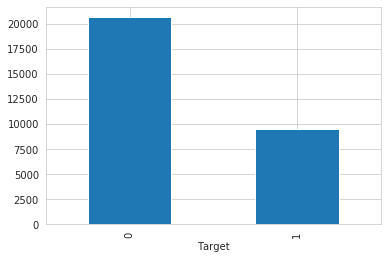

In [252]:

print("Shape of stage_2_train_labels.csv : {0}".format(labled_df.shape))
print("Unique values : {0}\n\n".format(labled_df['patientId'].value_counts().shape[0]))
## plot the distribution of classes
labled_df.groupby('Target').size().plot.bar()

In [367]:
## train
print("Total image files in 'stage_2_train_images' : {0}".format(len(os.listdir(train_images_folder))))


Total image files in 'stage_2_train_images' : 26684


Total no. of image files in 'stage_2_train_images' : `26684`     
Total no. of records in 'stage_2_train_labels.csv' : `26684`  
Total no. of unique records in 'stage_2_detailed_class_info': `26684`     


They are consistent with each other !!

#### View the distribution of 3 different types of classes 


In [14]:
merged_df = labled_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')
print(merged_df.shape)
print("unique values in merged dataframe : {0}".format(len(merged_df['patientId'].unique())))
merged_df.sample(5)



(37629, 7)
unique values in merged dataframe : 26684


patientId      x      y  width  height  \
7855   49467153-bfcf-4d73-be8c-54dd133771c0    NaN    NaN    NaN     NaN   
13192  6fd0d3d2-a990-41a8-b843-94d2356afe42  355.0  360.0  202.0   411.0   
37125  27aa5880-422d-4084-b907-409754c89713    NaN    NaN    NaN     NaN   
20785  a1dc7fe9-1e55-4956-9f04-f99f624faefb    NaN    NaN    NaN     NaN   
35254  fbbd1c86-6545-4cf7-8273-0c77161c847c    NaN    NaN    NaN     NaN   

       Target                         class  
7855        0  No Lung Opacity / Not Normal  
13192       1                  Lung Opacity  
37125       0                        Normal  
20785       0                        Normal  
35254       0                        Normal

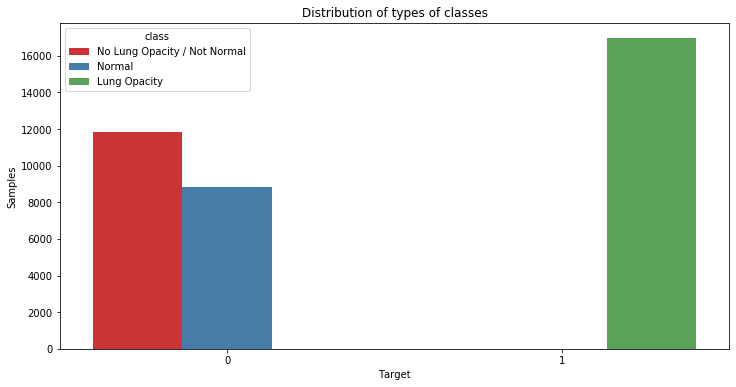

In [15]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = merged_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Samples': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Samples',hue='class',data=df, palette='Set1')
plt.title("Distribution of types of classes")
plt.show()

#### Combine both the csv 

In [28]:
combined_df = pd.merge(labled_df, class_info_df, how='inner', on='patientId')
print(combined_df.shape[0], 'combined cases')

37629 combined cases


In [0]:
# combined_df = pd.concat([labled_df, 
#                         class_info_df.drop('patientId',1)], 1)
# print(combined_df.shape[0], 'combined cases')
# combined_df.sample(10)
combined_svm_df = combined_df.copy()


#### Find lungs opacity intervals

We will filter out all the records with box values so that we can   
plot the ranges of the box. This will give us an vague idea of the localization of the target boxes for opacity.

In [30]:
final = combined_df.dropna()  ## this will filter all the records only with boxes
print(final.shape[0], 'combined cases')
final.sample(5)

16957 combined cases


patientId      x      y  width  height  \
13981  749fbf6d-b0ea-4118-91c7-a47d9d704f62  745.0  527.0  140.0   262.0   
33894  f263d63e-1715-4bd8-af5e-fa4e824fa55b  727.0  360.0  183.0   337.0   
5072   395cb95f-700c-4a77-89f1-dcbddf957552  528.0  251.0  217.0   381.0   
5839   3ce512cd-65c8-480c-9707-242b3715d3da  564.0  153.0  203.0   698.0   
4701   37a3ae61-b059-4972-9e28-c7bc02cd1ada  602.0  478.0  256.0   309.0   

       Target         class  
13981       1  Lung Opacity  
33894       1  Lung Opacity  
5072        1  Lung Opacity  
5839        1  Lung Opacity  
4701        1  Lung Opacity

<Figure size 432x288 with 0 Axes>

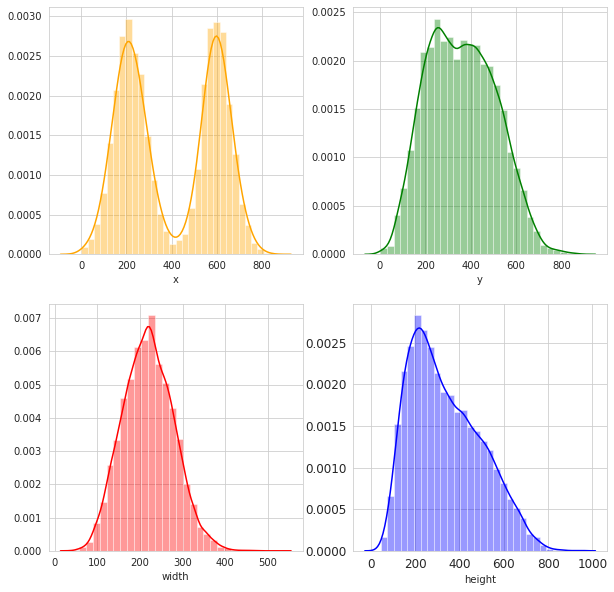

In [19]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(10,10))
sns.distplot(final['x'],kde=True,bins=30, color="orange", ax=ax[0,0])
sns.distplot(final['y'],kde=True,bins=30, color="green", ax=ax[0,1])
sns.distplot(final['width'],kde=True,bins=30, color="red", ax=ax[1,0])
sns.distplot(final['height'],kde=True,bins=30, color="blue", ax=ax[1,1])

locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [0]:
## Centers of rectangle

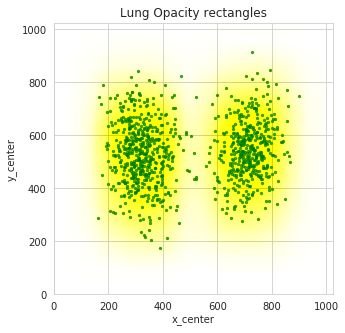

In [102]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
final1 = final.sample(1000)
final1['x_center'] = final1['x'] + final1['width'] / 2
final1['y_center'] = final1['y'] + final1['height'] / 2
plt.title("Lung Opacity rectangles")
final1.plot.scatter(x='x_center', y='y_center', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.7, marker=".", color="green")
for i, sample in final1.iterrows():
    ax.add_patch(Rectangle(xy=(sample['x'], sample['y']),
                width=sample['width'],height=sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [0]:
final.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

class  Target  Patient Count
0  Lung Opacity       1           9555

In [368]:
box_df = combined_df.groupby('patientId').size().reset_index(name='boxes')
combined_df = pd.merge(combined_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

boxes  patients
0      1     23286
1      4      3266
2      9       119
3     16        13

In [369]:
box1_df = final.groupby('patientId').size().reset_index(name='boxes1')
final = pd.merge(final, box1_df, on='patientId')
box1_df.groupby('boxes1').size().reset_index(name='patients')

boxes1  patients
0       1      2614
1       2      3266
2       3       119
3       4        13

In [133]:
print(box_df.iloc[8])

patientId    00704310-78a8-4b38-8475-49f4573b2dbb
x                                             323
y                                             577
width                                         160
height                                        104
Target                                          1
Name: 8, dtype: object


#### View the individual images with different cmap

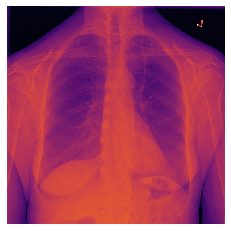

In [325]:
pid_45 = box_df['patientId'][45]
view_individual_patient_image(pid_45, cmap_value=pylab.cm.inferno)

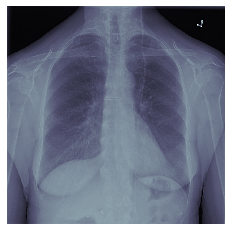

In [324]:
view_individual_patient_image(pid_45, cmap_value=pylab.cm.bone)

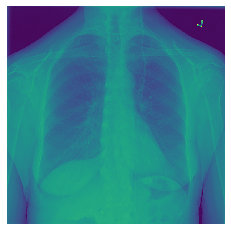

In [327]:
view_individual_patient_image(pid_45, cmap_value=pylab.cm.viridis)

In [0]:
def parse_data_dict(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows(): 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': get_dcm_image(pid),
                'label': row['Target'],
                'boxes': []}

        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [363]:
parsed = parse_data_dict(labled_df)
print(len(parsed.keys()))

26684


In [0]:

# print(parsed['003d8fa0-6bf1-40ed-b54c-ac657f8495c5']) ## normal 
# print(parsed['00704310-78a8-4b38-8475-49f4573b2dbb']) ## opaque

#### Visualize the boxes

In [0]:
def overlay_box(pixels, box, rgb, stroke=8):
    #get integers coordinates
    box = [int(b) for b in box]
    
    #get x,y coordinates
    y1, x1, height, width = box
    y2 = y1 + height 
    x2 = x1 + width

    pixels[y1:y1 + stroke, x1:x2] = rgb
    pixels[y2:y2 + stroke, x1:x2] = rgb
    pixels[y1:y2, x1:x1 + stroke] = rgb
    pixels[y1:y2, x2:x2 + stroke] = rgb

    return pixels

def construct_boxes(image, size=(20,10)):
    '''Create boxes using the lables information of 
    boxes given in stage_2_train_labels.csv
    '''
    fig=plt.figure(figsize=size)
    d = pydicom.read_file(image['dicom'])
    pixels = d.pixel_array
    #Convert from 3d for rgb pixels
    pixels = np.stack([pixels] * 3, axis=2)

    for box in image['boxes']:
        rgb = [0,255,0]
        pixels = overlay_box(pixels=pixels, box=box, rgb=rgb, stroke=8)
    pylab.imshow(pixels, cmap=pylab.cm.viridis)
    pylab.axis('off')
    plt.show()

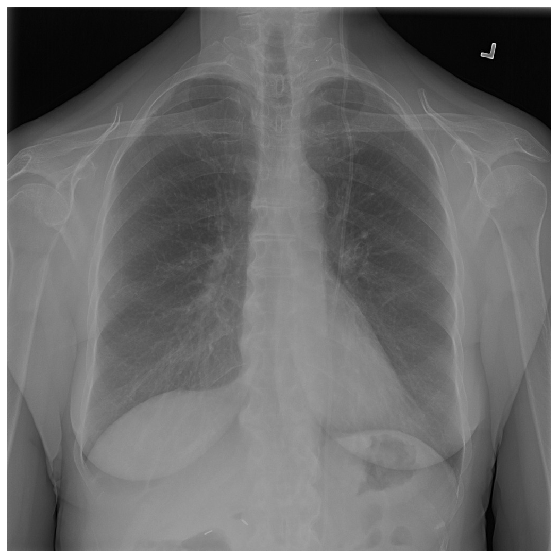

In [316]:
construct_boxes(parsed['01aad2a6-3b93-45e3-bf37-2d73348cb6fc'])

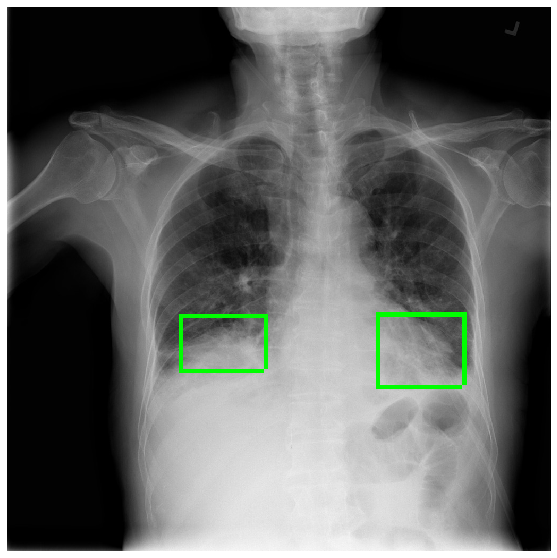

In [317]:

construct_boxes(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])

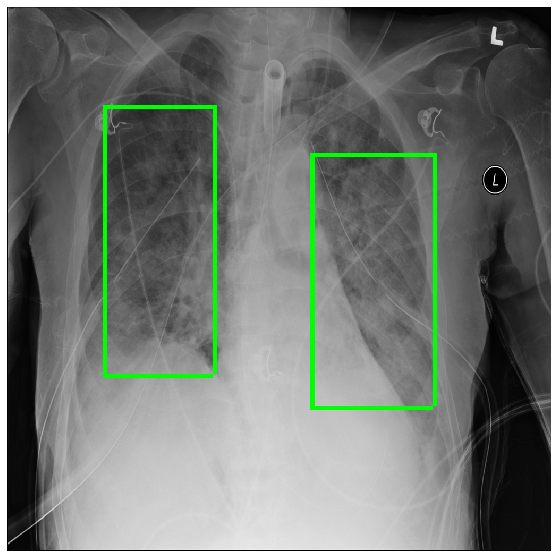

In [307]:
construct_boxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])

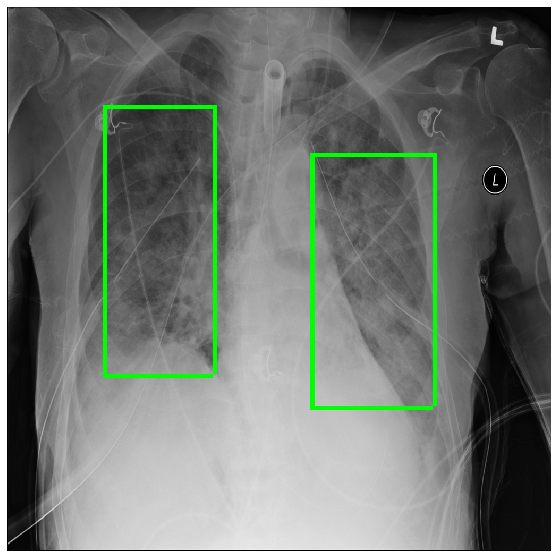

In [308]:
construct_boxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])


In [20]:
pneumonia_locations = {}
# load table
with open(labeled_boxes_csv, mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

print(len(pneumonia_locations))

6012


#### Split the dataset into train and test

In [21]:
## train
filenames = os.listdir(train_images_folder)
print("Total image files in 'stage_2_train_images' : {0}".format(len(filenames)))

## test 
filenames_test = os.listdir(test_images)
print("Total image files in 'stage_2_train_images' : {0}".format(len(filenames_test)))


# split into train and test filenames by 80/20
test = int(len(filenames) * 0.2)
train = filenames[test:]
test = filenames[:test]
print('Train :', len(train))
print('Test : ', len(test))

Total image files in 'stage_2_train_images' : 26684
Total image files in 'stage_2_train_images' : 3000
Train : 21348
Test :  5336


### Convolutional Neural Network

**Data augmentations**    
Images can vary in dimensions and rotation, we need to to take care of the 
image augmentations while training. These augmentation includes the  
* Resizing 
* Rotation 
* Horizontal flips     

We will using `keras.utils.Sequence` and override it to generate the data efficiently. 

In [0]:
'''Generic class to augment the image data
This function is used to generate data on the flow as we cannot get all the data at once due to computational inability
'''

class Generator(keras.utils.Sequence):
    
    def __init__(self, folder, 
                 filenames, 
                 pneumonia_locations=None, 
                 batch_size=16, 
                 image_size=320, 
                 shuffle=True, 
                 predict=False):
       
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.predict = predict
        self.folder = train_images_folder
        self.augment = augment
        self.filenames = filenames
        self.on_epoch_end()
        
    def __load__(self, filename):
        #load all the files in numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        #load zeros
        msk = np.zeros(img.shape)
        filename = filename.split('.')[0]
        if filename in pneumonia_locations:
            for location in pneumonia_locations[filename]:
                #add 1 instead of 0 at pneumonia locations
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # change sizes of images
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        #resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        img = np.expand_dims(img, -1)
        return img
    
    def __getitem__(self, index):
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.predict:
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            imgs = np.array(imgs)
            return imgs, filenames
        else:
            items = [self.__load__(filename) for filename in filenames]
            imgs, msks = zip(*items)
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
            
    def __len__(self):
        if self.predict:
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            return int(len(self.filenames) / self.batch_size)

In [0]:
BATCH_SIZE = 16
IMAGE_SIZE = 320

In [0]:
def downSample(channels, inputs):
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def resNet(channels, inputs):
    x = keras.layers.BatchNormalization(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def myRESNET(input_size, channels, blocks=2, depth=3):
    #connect Input layer
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    #connect Residual layer
    for d in range(depth):
        channels = channels * 2
        x = downSample(channels, x)
        for b in range(blocks):
            x = resNet(channels, x)
    #connect output layer
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2DTranspose(128, (8,8), (4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(64,1, padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(1, 1, activation='relu')(x)
    outputs = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

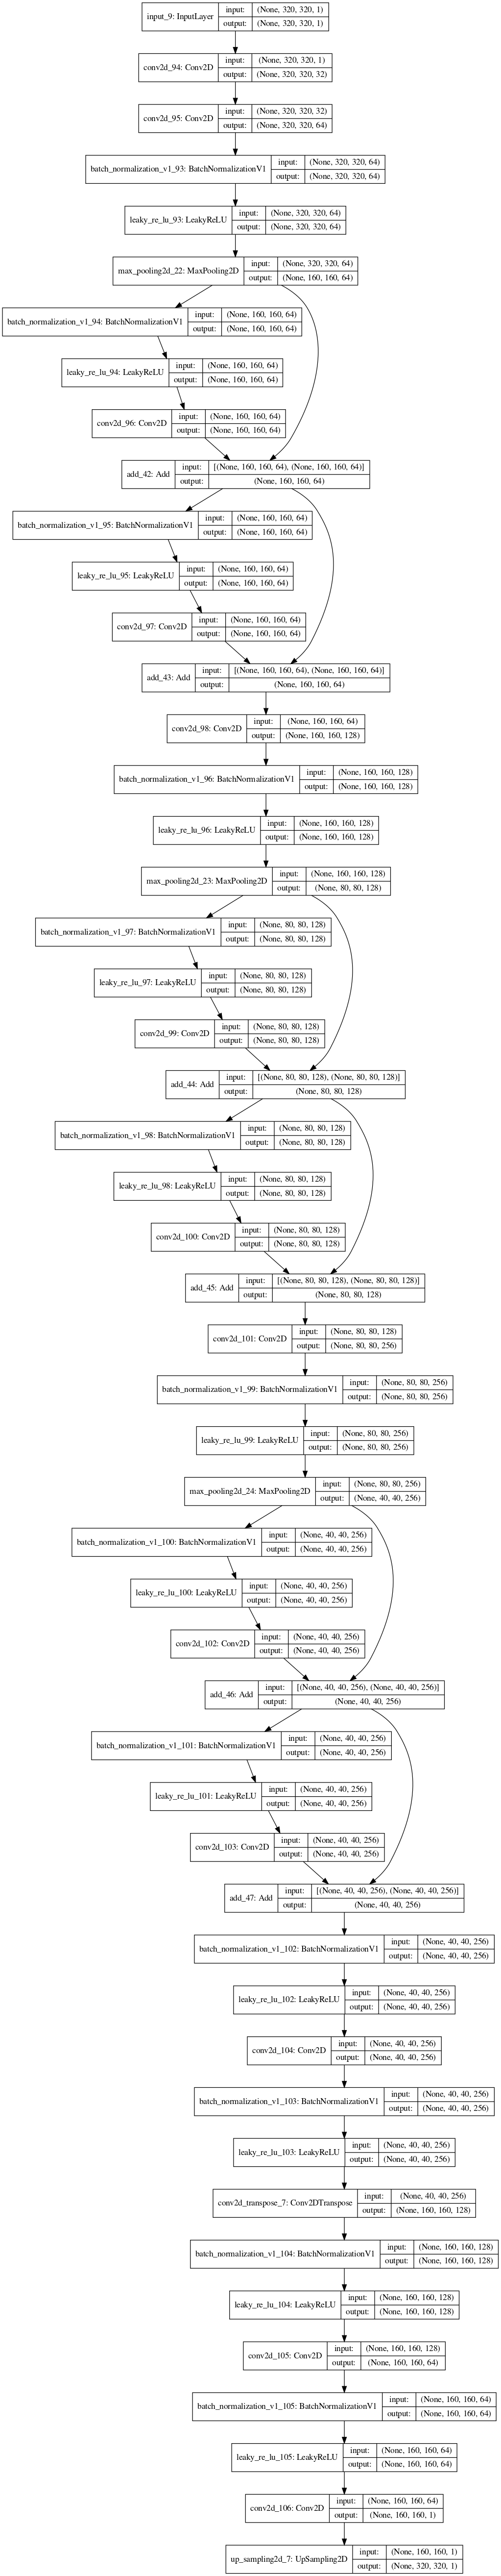

In [14]:
## plot the model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

model = myRESNET(input_size=320, channels=32, blocks=2, depth=3)
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True, dpi=90)


In [25]:
# create network and compiler
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#annealing cosine learning
def cosine(x):
    lr = 0.002
    epochs = 15
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine)

# create train and validation generators
train_gen = Generator(train_images_folder, train, pneumonia_locations, batch_size=16, image_size=320, shuffle=True, augment=True, predict=False)
test_gen = Generator(train_images_folder, test, pneumonia_locations, batch_size=16, image_size=320, shuffle=False, predict=False)

print(model.summary())
                                                

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 320, 320, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 320, 320, 64) 2048        conv2d_13[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_13 (Batc (None, 320, 320, 64) 256         conv2d_14[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [0]:
myRESNET = model.fit_generator(train_gen, validation_data=test_gen, callbacks=[learning_rate], epochs=1, shuffle=True)

In [0]:
duplicate_RESNET = myRESNET

In [0]:
print(myRESNET.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [0]:
print(myRESNET.history['accuracy'])
print(myRESNET.history['val_accuracy'])


[0.97607964]
[0.96008945]


### Support vector machine 

In [0]:
## from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.metrics import auc
# from sklearn.metrics import plot_roc_curve
import numpy as np
import pandas as pd
from numpy import interp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [34]:
combined_svm_df.shape
combined_svm_df.sample(20)
forSVMFinal_df = combined_svm_df.drop('class', axis = 1).copy()
forSVMFinal_df.sample(5)

patientId      x      y  width  height  \
3788   33c24f1e-7526-4d84-a057-facdc540f22b  213.0  236.0  284.0   559.0   
23439  b080119c-b27f-486e-a803-32634a898536    NaN    NaN    NaN     NaN   
20869  a27e3a17-eb04-484c-a9a2-bdabe6e68bc6    NaN    NaN    NaN     NaN   
34444  f6484a63-db0b-4171-810f-ad895c44dbe3    NaN    NaN    NaN     NaN   
24116  b38eb728-d36c-457e-a05c-c81a6d28edf8  521.0  428.0   79.0   110.0   

       Target  
3788        1  
23439       0  
20869       0  
34444       0  
24116       1

In [0]:
## fresh load file again and resets the variables
## load and set file/folder variables
details_class_info_csv = os.path.join(data_dir, 'stage_2_detailed_class_info.csv')
labeled_boxes_csv = os.path.join(data_dir, 'stage_2_train_labels.csv')
train_images_folder = os.path.join(data_dir, 'stage_2_train_images')
test_images = os.path.join(data_dir, 'stage_2_test_images')



In [36]:
## load the csv's as dataframe 
labled_df_tmp = pd.read_csv(labeled_boxes_csv)
print("Content of the stage_2_train_labels.csv: \n")
labled_df_tmp.head()
## second csv
class_info_df_tmp = pd.read_csv(details_class_info_csv)
print("\n\n\nContent of the stage_2_detailed_class_info.csv:\n")
class_info_df_tmp.head()

Content of the stage_2_train_labels.csv: 




Content of the stage_2_detailed_class_info.csv:



patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [37]:
df = pd.merge(left = class_info_df_tmp, right = labled_df_tmp, how = 'left', on = 'patientId')

del class_info_df_tmp, labled_df_tmp
gc.collect()

df = df.drop_duplicates()
df_meta = df.drop('class', axis = 1).copy()
df_meta.sample(20)

patientId      x      y  width  height  \
25775  bac7d309-34ab-4eb8-86a0-ccb02fb03fdc    NaN    NaN    NaN     NaN   
25786  bad209bb-8814-4a94-9e27-4370052e3b85  181.0  503.0  261.0   268.0   
1843   156a563f-4580-41d9-b930-2c6859478b50  668.0  401.0  192.0   346.0   
25101  b7f366aa-2776-4a9f-ab74-2bd4ce65554b    NaN    NaN    NaN     NaN   
34794  f89807dc-088f-403a-84a1-8137ce06aa35    NaN    NaN    NaN     NaN   
13958  747a4e20-847e-4e45-b4cf-2ef247b51f1e    NaN    NaN    NaN     NaN   
35807  ff8563d5-cc01-4dce-87c6-bf12e748955c    NaN    NaN    NaN     NaN   
14715  796c0726-bde4-4ff2-aa00-11587b3a8a0c    NaN    NaN    NaN     NaN   
14172  75ed8091-a23e-4dba-84fa-014f5920e9a5    NaN    NaN    NaN     NaN   
18159  8f9210c1-0b2c-4d37-b08d-dfd608fbcfe2    NaN    NaN    NaN     NaN   
19320  9789f8bd-ea8b-4cc2-a3f9-3571693d8da4    NaN    NaN    NaN     NaN   
27706  c538cfaa-3ee3-4a05-a67d-0224e244bf34    NaN    NaN    NaN     NaN   
6768   414f23c1-9c21-41e1-a52c-8033420afc91    NaN    NaN    NaN     NaN   
32110  e6063be4-ce29-40d6-9ab3-bbb746cda7fb    NaN    NaN    NaN     NaN   
28692  cc53205d-f71b-4e22-bfd5-1d722a263e44    NaN    NaN    NaN     NaN   
33626  f0a61294-3bab-42a2-8b6c-489a696db8bc    NaN    NaN    NaN     NaN   
34772  f8767c5d-9024-43d9-9044-843f2cec00c7  669.0  342.0  202.0   514.0   
33865  f2252c5e-084f-4653-8fa9-0dc963f0755b    NaN    NaN    NaN     NaN   
32023  e57849e2-d2b9-4ab6-a3e3-0263a4a78b33    NaN    NaN    NaN     NaN   
30976  dd9ce726-1d01-45e5-8a71-2ae8663ba3a9    NaN    NaN    NaN     NaN   

       Target  
25775       0  
25786       1  
1843        1  
25101       0  
34794       0  
13958       0  
35807       0  
14715       0  
14172       0  
18159       0  
19320       0  
27706       0  
6768        0  
32110       0  
28692       0  
33626       0  
34772       1  
33865       0  
32023       0  
30976       0

In [38]:
## if df_meta.pkl pickle is not available then run the following.
## it takes couple of hrs to parse through each file
dcm_columns = None
for n, pid in enumerate(df_meta['patientId'].unique()):
    dcm_file = get_dcm_image(pid)
    dcm_data = pydicom.read_file(dcm_file)
    
    if not dcm_columns:
        dcm_columns = dcm_data.dir()
        dcm_columns.remove('PixelSpacing')
        dcm_columns.remove('PixelData')
    
    for col in dcm_columns:
        if not (col in df_meta.columns):
            df_meta[col] = np.nan
        index = df_meta[df_meta['patientId'] == pid].index
        df_meta.loc[index, col] = dcm_data.data_element(col).value
        
    del dcm_data
    
gc.collect()

df_meta.head()


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

  AccessionNumber  BitsAllocated  BitsStored BodyPartExamined  ...  \
0                            8.0         8.0            CHEST  ...   
1                            8.0         8.0            CHEST  ...   
2                            8.0         8.0            CHEST  ...   
3                            8.0         8.0            CHEST  ...   
4                            8.0         8.0            CHEST  ...   

   SamplesPerPixel SeriesDescription  \
0              1.0          view: PA   
1              1.0          view: PA   
2              1.0          view: AP   
3              1.0          view: PA   
4              1.0          view: AP   

                                   SeriesInstanceUID  SeriesNumber  \
0  1.2.276.0.7230010.3.1.3.8323329.28530.15178744...           1.0   
1  1.2.276.0.7230010.3.1.3.8323329.26024.15178744...           1.0   
2  1.2.276.0.7230010.3.1.3.8323329.11252.15178743...           1.0   
3  1.2.276.0.7230010.3.1.3.8323329.2293.151787429...           1.0   
4  1.2.276.0.7230010.3.1.3.8323329.6379.151787432...           1.0   

  SpecificCharacterSet StudyDate StudyID  \
0           ISO_IR 100  19010101           
1           ISO_IR 100  19010101           
2           ISO_IR 100  19010101           
3           ISO_IR 100  19010101           
4           ISO_IR 100  19010101           

                                    StudyInstanceUID  StudyTime ViewPosition  
0  1.2.276.0.7230010.3.1.2.8323329.28530.15178744...  000000.00           PA  
1  1.2.276.0.7230010.3.1.2.8323329.26024.15178744...  000000.00           PA  
2  1.2.276.0.7230010.3.1.2.8323329.11252.15178743...  000000.00           AP  
3  1.2.276.0.7230010.3.1.2.8323329.2293.151787429...  000000.00           PA  
4  1.2.276.0.7230010.3.1.2.8323329.6379.151787432...  000000.00           AP  

[5 rows x 39 columns]

In [0]:
## save to pickle so that we dont have to parse the images again
df_meta.to_pickle("./df_meta.pkl")

In [0]:
## read from pickle 
df_meta = pd.read_pickle("./df_meta.pkl")

In [41]:
print(df_meta.head())

                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

  AccessionNumber  BitsAllocated  BitsStored BodyPartExamined  ...  \
0                            8.0         8.0            CHEST  ...   
1                            8.0         8.0            CHEST  ...   
2                            8.0         8.0            CHEST  ...   
3                            8.0         8.0            CHEST  ...   
4                            8.0         8.0            CHEST  ...   

   SamplesPerPixel SeriesDescription  \
0              1.0          view: PA   
1              1.0

In [0]:
def get_meta_data(pid, columns):
    dicom = pydicom.read_file(get_dcm_image(pid))
    wantedColumn = getattr(dicom, columns)
    return wantedColumn

In [0]:
columns = ['PatientSex', 'PatientAge', 'ViewPosition']
for i in columns:
    forSVMFinal_df[i] = forSVMFinal_df['patientId'].apply(lambda l: get_meta_data(l, i))
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(pd.to_numeric, errors='coerce')
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(lambda l: l if l<120 else np.nan)


In [46]:
forSVMFinal_df.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

  PatientSex  PatientAge ViewPosition  
0          F        51.0           PA  
1          F        48.0           PA  
2          M        19.0           AP  
3          M        28.0           PA  
4          F        32.0           AP

In [0]:
svmDuplicate_df = forSVMFinal_df

In [48]:
svmDuplicate_df.sample(20)

patientId      x      y  width  height  \
11077  60c7d6a1-9aad-452f-9789-918056b955ad    NaN    NaN    NaN     NaN   
6816   419d2d79-4bdc-482f-9a21-560f833ae232    NaN    NaN    NaN     NaN   
12951  6e26360c-3342-449c-907a-803c06d59830    NaN    NaN    NaN     NaN   
10785  5eaa3abe-8432-4bb4-9b51-685bd0663eb1    NaN    NaN    NaN     NaN   
12074  68108123-8750-455d-ba82-667373a00be5    NaN    NaN    NaN     NaN   
27143  c252072c-c7c9-40a8-819b-5c7952d10bf2  267.0  247.0  201.0   270.0   
20149  9d89e97a-153b-4d35-b72a-db2b009f993e    NaN    NaN    NaN     NaN   
12640  6c1c7f04-a78e-40f5-836c-4f41d4b300b1    NaN    NaN    NaN     NaN   
6355   3f1d7f08-05a4-4ce7-923e-7b1159c509d8  187.0  303.0  207.0   203.0   
18504  91b0043a-35bd-4cf9-b338-1cbc9b05b76d    NaN    NaN    NaN     NaN   
20118  9d487748-1f51-48aa-afdc-a6225be8bdba    NaN    NaN    NaN     NaN   
29781  d4683e9b-ee14-40e1-a9f9-1eebd8d125ee  285.0  301.0  226.0   412.0   
24253  b4198862-dc25-4cff-acd5-b0b954bd3a03  165.0  246.0  275.0   519.0   
35680  feb18c4a-f0b6-4987-8564-22ca37b19f6b    NaN    NaN    NaN     NaN   
28924  cde08a05-31aa-44f6-8fc5-c16bb94d9432  601.0  253.0  234.0   387.0   
7101   440d3b62-7638-48ab-ab66-381833acb954    NaN    NaN    NaN     NaN   
23675  b1831e52-f668-47a9-a900-f42924698045  209.0  501.0  258.0   249.0   
2566   1bf08f3b-a273-4f51-bafa-b55ada2c23b5  631.0  474.0  129.0   208.0   
1105   0a9c4c04-5918-48da-9ba1-b2a3add66ae9   92.0  141.0  347.0   527.0   
3040   2e826ff4-4329-4b2b-9467-c4506ab1f6ba    NaN    NaN    NaN     NaN   

       Target PatientSex  PatientAge ViewPosition  
11077       0          F        56.0           PA  
6816        0          F        21.0           PA  
12951       0          F        29.0           PA  
10785       0          M        48.0           AP  
12074       0          F        35.0           PA  
27143       1          F        56.0           AP  
20149       0          F        19.0           AP  
12640       0          M        61.0           PA  
6355        1          F        56.0           PA  
18504       0          M        29.0           PA  
20118       0          M        54.0           PA  
29781       1          F        68.0           AP  
24253       1          M        57.0           AP  
35680       0          F        54.0           PA  
28924       1          M        20.0           AP  
7101        0          M        40.0           PA  
23675       1          M        59.0           PA  
2566        1          F        21.0           AP  
1105        1          M        53.0           AP  
3040        0          M        46.0           AP

In [0]:
## mapping the categorical values to the numeric
svmDuplicate_df['PatientSex'] = svmDuplicate_df['PatientSex'].map({'F': 0, 'M': 1}) 
svmDuplicate_df['ViewPosition'] = svmDuplicate_df['ViewPosition'].map({'PA': 0, 'AP': 1}) 

In [50]:
forSVMFinal_df.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   PatientSex  PatientAge  ViewPosition  
0           0        51.0             0  
1           0        48.0             0  
2           1        19.0             1  
3           1        28.0             0  
4           0        32.0             1

In [0]:
svm_df = forSVMFinal_df[['PatientSex', 'PatientAge', 'ViewPosition', 'Target']]

In [43]:
svm_df.sample(20)

PatientSex  PatientAge  ViewPosition  Target
21622           0        38.0             0       0
3438            1        46.0             1       1
6368            1        21.0             1       0
6215            0        29.0             1       1
17514           0        48.0             0       0
23757           1        72.0             0       0
35018           1        53.0             0       0
20859           1        67.0             1       1
15691           1        31.0             0       0
9006            1        49.0             0       0
16618           1        34.0             0       1
1455            1        39.0             0       1
35034           1        14.0             1       0
23197           1        66.0             0       0
24100           0        63.0             1       1
7070            0        33.0             0       0
21220           1        19.0             1       0
9198            0        39.0             1       1
30609           1        61.0             0       0
11128           1        39.0             0       0

In [52]:
## save the metadata information in csv
METADATA_FILE = "svm_metadat_df.csv"
svm_df = svm_df.dropna()
svm_df.to_csv(METADATA_FILE, index = False)
print(svm_df.shape)

(37624, 4)


In [0]:
## finally traning the SVM 

heart = pd.read_csv(METADATA_FILE);
array = heart.values
X = array[:,0:3]
y = array[:,3]


cv = StratifiedKFold(n_splits=10)
svm_model = SVC(kernel='rbf', gamma=0.05, C=1.0)
aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    svm_model.fit(X[train], y[train])
    figure = plot_roc_curve(svm_model, X[test], y[test],
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, figure.fpr, figure.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(figure.roc_auc)
    print('AUC = ', end =""),
    print(float(figure.roc_auc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print('Mean AUC = ', end ="")
print(mean_auc)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.show()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
svm_model = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_model.fit(x_train, y_train)
predictions = svm_model.predict(x_test)
score = svm_model.score(x_test, y_test)
print('Accuracy =',score)

### Logistic Regression

In [0]:
## imports 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
# from sklearn.metrics import plot_roc_curve
import numpy as np
import pandas as pd
from numpy import interp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:


heart = pd.read_csv(METADATA_FILE);
array = heart.values
X = array[:,0:3]
y = array[:,3]
n_samples, n_features = X.shape


# 10 fold cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(max_iter=1000)
aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    figure = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, figure.fpr, figure.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(figure.roc_auc)
    print('AUC = ', end =""),
    print(float(figure.roc_auc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print('Mean AUC = ', end ="")
print(mean_auc)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.show()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
score = classifier.score(x_test, y_test)
print('Accuracy =',score)